In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import random
import matplotlib
from matplotlib import pyplot as plt
import statistics
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import backend as K
#import keras.backend.tensorflow_backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from os.path import basename
#import seaborn as sns
# from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17091351416142659435
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2050938198405712026
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8641988302702011146
physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
workdir = "D://ResNetIC50//Dataset//MEDG-61K"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]

dataset = np.load(workdir + "//MEDG61K_dataset.npz") # input file
ss0 = np.load(workdir + '//MEDG61K_dataset_nnnr0.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 29


In [8]:
x.shape

(61633, 42526)

In [9]:
training_image_array.shape

(55470, 42526)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(55470, 42526, 1) (55470,) (6163, 42526, 1) (6163,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (55470, 42526, 1)
55470 train samples
6163 test samples


In [15]:
training_image_array.shape

(55470, 42526)

In [16]:
# In[10]:
with tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Model: "Test_v2_DNN20190327"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 42526, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 21263, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 4252, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4252, 16)     64          max_pooling1d[0][0]              
________________________________________________________________________________

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2022-02-11 20:52:21.520948
Epoch 1/150
555/555 [==============================] - 90s 149ms/step - loss: 6.6277 - mse: 6.6277 - mae: 2.0006 - val_loss: 2.0769 - val_mse: 2.0769 - val_mae: 1.0705
Epoch 2/150
555/555 [==============================] - 82s 149ms/step - loss: 1.8374 - mse: 1.8374 - mae: 1.0325 - val_loss: 1.7010 - val_mse: 1.7010 - val_mae: 0.9662
Epoch 3/150
555/555 [==============================] - 82s 148ms/step - loss: 1.6018 - mse: 1.6018 - mae: 0.9668 - val_loss: 1.4766 - val_mse: 1.4766 - val_mae: 0.9106
Epoch 4/150
555/555 [==============================] - 83s 149ms/step - loss: 1.4408 - mse: 1.4408 - mae: 0.9072 - val_loss: 1.5592 - val_mse: 1.5592 - val_mae: 0.9161
Epoch 5/150
555/555 [==============================] - 83s 149ms/step - loss: 1.3175 - mse: 1.3175 - mae: 0.8747 - val_loss: 1.4066 - val_mse: 1.4066 - val_mae: 0.8725
Epoch 6/150
555/555 [==============================] - 83s 150ms/step - loss: 1.2014 - mse: 1.2014 - mae: 0.8324 - val_lo

555/555 [==============================] - 83s 150ms/step - loss: 0.1899 - mse: 0.1899 - mae: 0.3344 - val_loss: 0.9296 - val_mse: 0.9296 - val_mae: 0.6917
Epoch 50/150
555/555 [==============================] - 83s 149ms/step - loss: 0.1858 - mse: 0.1858 - mae: 0.3325 - val_loss: 0.9319 - val_mse: 0.9319 - val_mae: 0.7018
Epoch 51/150
555/555 [==============================] - 83s 150ms/step - loss: 0.1824 - mse: 0.1824 - mae: 0.3306 - val_loss: 0.9466 - val_mse: 0.9466 - val_mae: 0.7006
Epoch 52/150
555/555 [==============================] - 83s 149ms/step - loss: 0.1696 - mse: 0.1696 - mae: 0.3183 - val_loss: 0.9523 - val_mse: 0.9523 - val_mae: 0.7040
Epoch 53/150
555/555 [==============================] - 83s 149ms/step - loss: 0.1756 - mse: 0.1756 - mae: 0.3230 - val_loss: 0.9544 - val_mse: 0.9544 - val_mae: 0.7098
Epoch 54/150
555/555 [==============================] - 83s 150ms/step - loss: 0.1689 - mse: 0.1689 - mae: 0.3179 - val_loss: 0.9395 - val_mse: 0.9395 - val_mae: 0.7016

555/555 [==============================] - 83s 150ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2434 - val_loss: 0.9362 - val_mse: 0.9362 - val_mae: 0.6946
Epoch 98/150
555/555 [==============================] - 83s 149ms/step - loss: 0.1017 - mse: 0.1017 - mae: 0.2440 - val_loss: 0.9311 - val_mse: 0.9311 - val_mae: 0.6920
Epoch 99/150
555/555 [==============================] - 83s 150ms/step - loss: 0.1049 - mse: 0.1049 - mae: 0.2482 - val_loss: 0.9187 - val_mse: 0.9187 - val_mae: 0.6870
Epoch 100/150
555/555 [==============================] - 83s 149ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2431 - val_loss: 0.9242 - val_mse: 0.9242 - val_mae: 0.6873
Epoch 101/150
555/555 [==============================] - 83s 150ms/step - loss: 0.0959 - mse: 0.0959 - mae: 0.2373 - val_loss: 0.9228 - val_mse: 0.9228 - val_mae: 0.6879
Epoch 102/150
555/555 [==============================] - 83s 150ms/step - loss: 0.0970 - mse: 0.0970 - mae: 0.2391 - val_loss: 0.9228 - val_mse: 0.9228 - val_mae: 0.6

555/555 [==============================] - 83s 149ms/step - loss: 0.0726 - mse: 0.0726 - mae: 0.2049 - val_loss: 0.9290 - val_mse: 0.9290 - val_mae: 0.6870
Epoch 146/150
555/555 [==============================] - 83s 149ms/step - loss: 0.0752 - mse: 0.0752 - mae: 0.2082 - val_loss: 0.9466 - val_mse: 0.9466 - val_mae: 0.6914
Epoch 147/150
555/555 [==============================] - 83s 149ms/step - loss: 0.0856 - mse: 0.0856 - mae: 0.2179 - val_loss: 0.9457 - val_mse: 0.9457 - val_mae: 0.6916
Epoch 148/150
555/555 [==============================] - 83s 149ms/step - loss: 0.0771 - mse: 0.0771 - mae: 0.2086 - val_loss: 0.9277 - val_mse: 0.9277 - val_mae: 0.6840
Epoch 149/150
555/555 [==============================] - 83s 149ms/step - loss: 0.0713 - mse: 0.0713 - mae: 0.2031 - val_loss: 0.9322 - val_mse: 0.9322 - val_mae: 0.6828
Epoch 150/150
555/555 [==============================] - 83s 150ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2046 - val_loss: 0.9303 - val_mse: 0.9303 - val_mae: 0

In [18]:
import json
# from keras.models import model_from_json, load_model
workdir = "D://ResNetIC50//Result//MEDG-61K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//MEDG61K_ResNet_nnnr0_model_fix_v3.h5')
with open(workdir + '//MEDG61K_ResNet_model_nnnr0_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [19]:
# Option 2: Save/Load the Entire Model
# from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//MEDG61K_ResNet_nnnr0_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [20]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

193/193 [==============================] - 4s 21ms/step - loss: 0.9303 - mse: 0.9303 - mae: 0.6909


In [21]:
test_eval

[0.9303377866744995, 0.9303377866744995, 0.6908604502677917]

In [22]:
accuracy = model_train.history['mse']
val_accuracy = model_train.history['val_mse']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [23]:
import matplotlib
from matplotlib import pyplot as plt

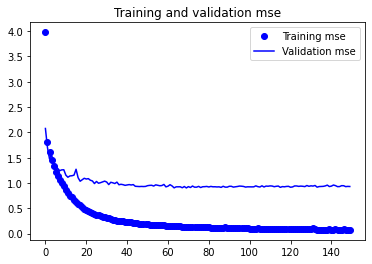

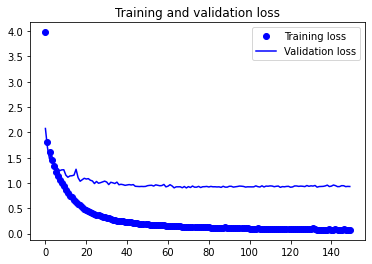

In [24]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes = model.predict(test_X)

In [26]:
predicted_value = predicted_classes

In [27]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [28]:
c.to_csv(workdir + '//MEDG61K_ResNet_nnnr0_pred_obs_table.csv')

In [29]:
c

,Predicted,Test
0,3.801374,4.019488
1,4.522639,4.874940
2,4.007802,3.469247
3,3.392780,3.188959
4,5.378875,5.234564
...,...,...
6158,4.490055,3.822629
6159,4.859638,5.123446
6160,4.596969,3.998526
6161,-2.986352,-1.653120


In [30]:
predicted_value.shape

(6163, 1)

In [31]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8802436068672334, intercept=0.28151171892565907, rvalue=0.9401508057595434, pvalue=0.0, stderr=0.004064682714877545, intercept_stderr=0.013977948974676808)

In [32]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.8835918416245337


In [33]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.9645402024833996


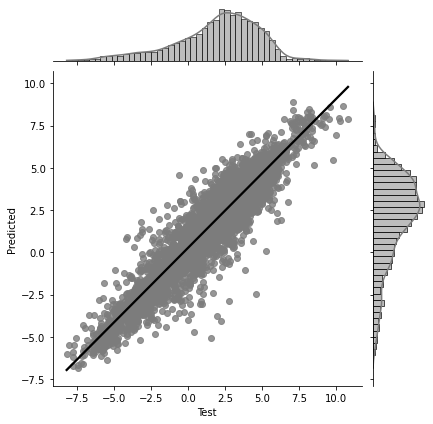

In [34]:
workdir = "D://ResNetIC50//Result//Figure//MEDG-61K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//MEDG61K_nnnr0_ResNet.png', dpi=300)